In [1]:
import os
import torch
#导入pytorch一个完整流程所需的可能全部的包
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader
torch.backends.cudnn.benchmark=True #用于加速GPU运算的代码
#导入作为辅助工具的各类包
import matplotlib.pyplot as plt #可视化
from time import time #计算时间、记录时间
import datetime
import random #控制随机性
import numpy as np
import pandas as pd
import gc #garbage collector 垃圾回收
# from plotpic import plotsample
from torchinfo import summary
# from EarlyStop import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
random.seed(1412) #random
np.random.seed(1412) #numpy.random
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#数据增强
trainT = T.Compose([T.RandomResizedCrop(224)
                   # ,T.RandomRotation(degrees=[-30, 30])
                   ,T.RandomHorizontalFlip()
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485, 0.456, 0.406]
                                ,std = [0.229, 0.224, 0.225])
                     ])
testT = T.Compose([
                    T.CenterCrop(224)
                      ,T.ToTensor()
                      ,T.Normalize(mean = [0.485, 0.456, 0.406]
                                   ,std = [0.229, 0.224, 0.225])
                   ]
                  )

In [5]:
train = torchvision.datasets.ImageFolder(root=r"F:\Data\New\train",
                                                 transform = trainT
                                                 )
test = torchvision.datasets.ImageFolder(root=r"F:\Data\New\test",
                                         transform = testT
                                         )



# num_samples = len(train)
# print(f"Number of samples in train dataset: {num_samples}")
# train = torchvision.datasets.SVHN(root = 'D://onedrive//OneDrive - yourdrive//Code//Notebook_workspace//SLPython//05Pytorch//Lesson 17//SVHN'
#                                   ,split = "train"
#                                   ,download = False
#                                   ,transform = trainT
#                                   )
# test = torchvision.datasets.SVHN(root = 'D://onedrive//OneDrive - yourdrive//Code//Notebook_workspace//SLPython//05Pytorch//Lesson 17//SVHN'
#                                  ,split = 'test'
#                                  ,download = False
#                                  ,transform = testT
#                                  )

In [6]:
import torchvision.transforms as T
from PIL import Image

# 获取一个样本（图像和标签）
sample_index = 500 # 可以选择任意索引
img, label = train[sample_index]

# 将张量图像转换回PIL图像
unnormalized_img = T.ToPILImage()(img)

# 显示图像和标签
print(f"Label: {label}")
unnormalized_img.show()


Label: 0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyResNet50(nn.Module):
    def __init__(self, num_classes=11):
        super(MyResNet50, self).__init__()
        resnet50 = models.resnet50(pretrained=True)

        # 保留resnet50的前几层
        self.conv1 = resnet50.conv1
        self.bn1 = resnet50.bn1
        self.relu = resnet50.relu
        self.maxpool = resnet50.maxpool
        self.layer1 = resnet50.layer1
        self.layer2 = resnet50.layer2
        self.layer3 = resnet50.layer3

        # 创建自定义的后3层
        self.layer4 = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [17]:
import torch
import torchvision.models as models

class MyResNet101(torch.nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super(MyResNet101, self).__init__()
        # 获取预训练的ResNet101模型并删除最后一层（全连接层）
        resnet101 = models.resnet101(pretrained=pretrained)
        resnet_without_fc = torch.nn.Sequential(*(list(resnet101.children())[:-1]))

        self.model = resnet_without_fc

        # 添加自定义层
        self.my_custom_layer1 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.my_custom_layer2 = torch.nn.ReLU(inplace=True)
        self.my_custom_layer3 = torch.nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, inputs):
        x = self.model(inputs)

        # 将输出展平至适用于全连接层的维度
        x = x.view(x.size(0), -1)

        # 执行自定义层
        x = self.my_custom_layer1(x)
        x = self.my_custom_layer2(x)
        x = self.my_custom_layer3(x)

        return x



In [9]:
class EarlyStopping():
    def __init__(self, patience = 20, tol = 0.005): #惯例地定义我们所需要的一切变量/属性\
        #当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        #就触发提前停止

        self.patience = patience
        self.tol = tol #tolerance，累积5次都低于tol才会触发停止
        self.counter = 0 #计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = False #True - 提前停止，False - 不要提前停止

    def __call__(self,val_loss):
        if self.lowest_loss == None: #这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #这一轮迭代的损失与历史最低损失之间的差 - 阈值

In [10]:
def IterOnce(net,criterion,opt,x,y):
    """
    对模型进行一次迭代的函数

    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    sigma = net.forward(x)
    loss = criterion(sigma,y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) #比起设置梯度为0，让梯度为None会更节约内存
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

In [11]:
def TestOnce(net,criterion,x,y):
    """
    对一组数据进行测试并输出测试结果的函数

    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    #对测试，一定要阻止计算图追踪
    #这样可以节省很多内存，加速运算
    with torch.no_grad():
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [12]:
def fit_test(net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH):

    SamplePerEpoch = batchdata.dataset.__len__()
    allsamples = SamplePerEpoch * epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol = tol)
    highestacc = None

    for epoch in range(1, epochs + 1):
        net.train()
        loss_train = 0
        correct_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            x = x.to(device, non_blocking = True)
            y = y.to(device, non_blocking = True).view(x.shape[0])
            correct, loss = IterOnce(net, criterion, opt, x, y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct

            if (batch_idx + 1) % 81 == 0:
                print('Epoch{}:[{}/{}({:.0f}%)]'.format( epoch
                                                         ,trainedsamples
                                                         ,allsamples
                                                         ,100*trainedsamples/allsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch
        trainlosslist.append(TrainLossThisEpoch)

        del x, y, correct, loss, correct_train, loss_train
        gc.collect()
        torch.cuda.empty_cache()

        net.eval()
        loss_test = 0
        correct_test = 0
        TestSample = testdata.dataset.__len__()

        for x, y in testdata:
            with torch.no_grad():
                x = x.to(device, non_blocking = True)
                y = y.to(device, non_blocking = True).view(x.shape[0])
                correct, loss = TestOnce(net, criterion, x, y)
                loss_test += loss
                correct_test += correct

        TestAccThisEpoch = float(correct_test*100)/TestSample
        TestLossThisEpoch = float(loss_test*100)/TestSample
        testlosslist.append(TestLossThisEpoch)

        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch ,TestLossThisEpoch, TrainAccThisEpoch, TestAccThisEpoch))

        if highestacc == None:
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname+".pt"))
            print("\t Weight Saved")


        #EarlyStopping
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == True:
            break

    print("Mission Complete")
    return  trainlosslist,testlosslist


In [13]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):

    torch.manual_seed(1412)
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    #分割数据
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                           ,drop_last=False, pin_memory=True) #线程 - 调度计算资源的最小单位
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                          ,drop_last=False, pin_memory=True)

    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)

    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)

    return trainloss, testloss

In [14]:
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
#建立目录用于存储模型选择结果
PATH = r"D:\Desktop"

#使用函数full_procedure中的默认参数，在模型选择时加入时间计算
#基于现有显存，batch_size被设置为256，对于CPU而言最好从64开始设置
#MyResNet
avgtime = [] #用来存放每次循环之后获得的训练时间
for i in range(1): #进行5次训练
    #设置随机数种子
    torch.manual_seed(1412)
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    #实例化
    # resnet18_ = m.resnet18()
    # resnet50_ = m.resnet50()
    # net = MyResNet50().to(device,non_blocking=True)

    # 实例化自定义模型
    net = MyResNet101(num_classes=11).to(device,non_blocking=True)
    # VGG_ = m.vgg16_bn()
    # net = MyVGG().to(device,non_blocking=True)
    #训练
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=500, bs=80
                                         ,modelname="model_seletion_resnet50"
                                         ,PATH = PATH
                                         ,tol = 10**(-3))
    avgtime.append(time()-start)
    plotloss(trainloss,testloss)

C:\Users\admin\.conda\envs\python3.7\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\admin\.conda\envs\python3.7\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch1:[6480/4575000(0%)]
	 Train Loss:238.289344, Test Loss:377.200799, Train Acc:18.601%, Test Acc:11.663%
Epoch2:[15630/4575000(0%)]
	 Train Loss:205.049973, Test Loss:271.340067, Train Acc:26.776%, Test Acc:12.779%
	 Weight Saved
Epoch3:[24780/4575000(1%)]
	 Train Loss:199.119645, Test Loss:266.277993, Train Acc:29.060%, Test Acc:15.012%
	 Weight Saved
Epoch4:[33930/4575000(1%)]
	 Train Loss:196.523197, Test Loss:253.085685, Train Acc:30.306%, Test Acc:15.261%
	 Weight Saved
Epoch5:[43080/4575000(1%)]
	 Train Loss:192.328279, Test Loss:272.440641, Train Acc:31.803%, Test Acc:12.655%
	 NOTICE: Early stopping counter 1 of 20
Epoch6:[52230/4575000(1%)]
	 Train Loss:188.995260, Test Loss:280.014365, Train Acc:34.000%, Test Acc:15.509%
	 Weight Saved
	 NOTICE: Early stopping counter 2 of 20
Epoch7:[61380/4575000(1%)]
	 Train Loss:186.495000, Test Loss:268.023942, Train Acc:35.410%, Test Acc:13.275%
	 NOTICE: Early stopping counter 3 of 20
Epoch8:[70530/4575000(2%)]
	 Train Loss:183.8432

KeyboardInterrupt: 

In [65]:
import torch

checkpoint = torch.load(r"D:\Desktop\model_seletion_resnet50.pt")
print("Keys in the checkpoint:")
for key in checkpoint.keys():
    print(key)


Keys in the checkpoint:
features.0.weight
features.1.weight
features.1.bias
features.1.running_mean
features.1.running_var
features.1.num_batches_tracked
features.4.0.conv1.weight
features.4.0.bn1.weight
features.4.0.bn1.bias
features.4.0.bn1.running_mean
features.4.0.bn1.running_var
features.4.0.bn1.num_batches_tracked
features.4.0.conv2.weight
features.4.0.bn2.weight
features.4.0.bn2.bias
features.4.0.bn2.running_mean
features.4.0.bn2.running_var
features.4.0.bn2.num_batches_tracked
features.4.0.conv3.weight
features.4.0.bn3.weight
features.4.0.bn3.bias
features.4.0.bn3.running_mean
features.4.0.bn3.running_var
features.4.0.bn3.num_batches_tracked
features.4.0.downsample.0.weight
features.4.0.downsample.1.weight
features.4.0.downsample.1.bias
features.4.0.downsample.1.running_mean
features.4.0.downsample.1.running_var
features.4.0.downsample.1.num_batches_tracked
features.4.1.conv1.weight
features.4.1.bn1.weight
features.4.1.bn1.bias
features.4.1.bn1.running_mean
features.4.1.bn1.run

In [21]:
# del net
gc.collect()
torch.cuda.empty_cache()
print(np.mean(avgtime))

nan


C:\Users\admin\.conda\envs\python3.7\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\admin\.conda\envs\python3.7\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
import os
import torch

def load_checkpoint(filepath, model):
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict)
    return model


PATH = r"D:\Desktop"
model_file = "model_seletion_resnet50.pt"  # 请替换为您的模型文件名
model_path = os.path.join(PATH, model_file)

avgtime = []
for i in range(1):
    torch.manual_seed(1412)
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    resnet50_ = m.resnet50()
    net = MyResNet50().to(device, non_blocking=True)
    net = load_checkpoint(model_path, net)  # 加载模型状态
    start = time()
    trainloss, testloss = full_procedure(net, epochs=1000, bs=10,
                                         modelname="model_seletion_resnet50_1",
                                         PATH=PATH,
                                         lr=0.1,
                                         tol=10**(-3))
    avgtime.append(time() - start)


NameError: name 'MyResNet50' is not defined

In [8]:
plotloss(trainloss,testloss)

NameError: name 'trainloss' is not defined

MyResNet_test1
Epoch1:[32000/3662850(1%)]
Epoch1:[64000/3662850(2%)]
	 Train Loss:145.966624, Test Loss:42.200350, Train Acc:49.947%, Test Acc:86.905%
Epoch2:[105257/3662850(3%)]
Epoch2:[137257/3662850(4%)]
	 Train Loss:45.295804, Test Loss:31.967725, Train Acc:85.855%, Test Acc:90.143%
	 Weight Saved
Epoch3:[178514/3662850(5%)]
Epoch3:[210514/3662850(6%)]
	 Train Loss:35.516944, Test Loss:24.002331, Train Acc:89.159%, Test Acc:93.208%
	 Weight Saved
Epoch4:[251771/3662850(7%)]
Epoch4:[283771/3662850(8%)]
	 Train Loss:31.458731, Test Loss:24.730457, Train Acc:90.393%, Test Acc:93.047%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/3662850(9%)]
Epoch5:[357028/3662850(10%)]
	 Train Loss:28.895587, Test Loss:20.115286, Train Acc:91.228%, Test Acc:94.345%
	 Weight Saved
Epoch6:[398285/3662850(11%)]
Epoch6:[430285/3662850(12%)]
	 Train Loss:26.874778, Test Loss:19.555366, Train Acc:91.997%, Test Acc:94.545%
	 Weight Saved
Epoch7:[471542/3662850(13%)]
Epoch7:[503542/3662850(14%)]
	 T

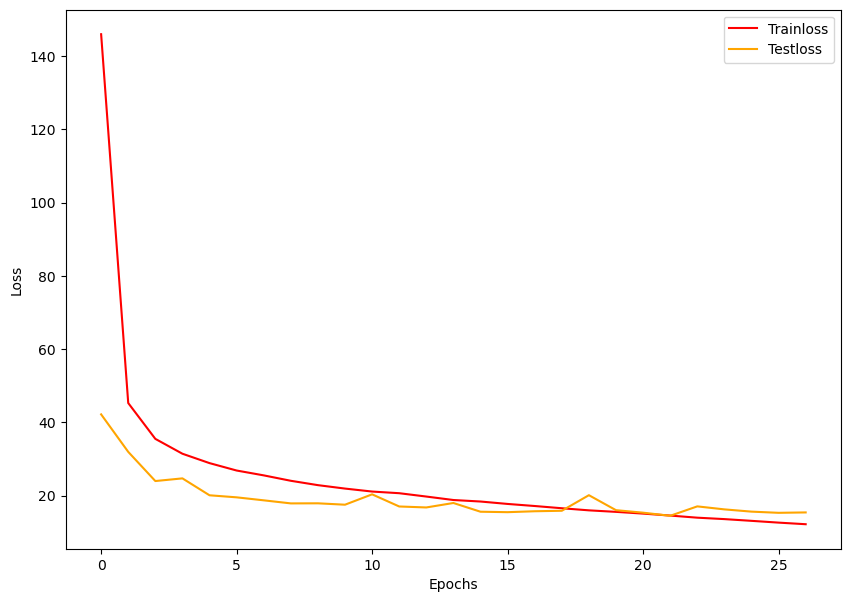

MyResNet_test2
Epoch1:[32000/3662850(1%)]
Epoch1:[64000/3662850(2%)]
	 Train Loss:147.335900, Test Loss:45.349988, Train Acc:49.477%, Test Acc:85.591%
Epoch2:[105257/3662850(3%)]
Epoch2:[137257/3662850(4%)]
	 Train Loss:45.096677, Test Loss:34.985945, Train Acc:85.996%, Test Acc:89.159%
	 Weight Saved
Epoch3:[178514/3662850(5%)]
Epoch3:[210514/3662850(6%)]
	 Train Loss:35.400573, Test Loss:23.111567, Train Acc:89.196%, Test Acc:93.416%
	 Weight Saved
Epoch4:[251771/3662850(7%)]
Epoch4:[283771/3662850(8%)]
	 Train Loss:31.404896, Test Loss:22.425205, Train Acc:90.368%, Test Acc:93.723%
	 Weight Saved
Epoch5:[325028/3662850(9%)]
Epoch5:[357028/3662850(10%)]
	 Train Loss:28.894106, Test Loss:20.056869, Train Acc:91.243%, Test Acc:94.445%
	 Weight Saved
Epoch6:[398285/3662850(11%)]
Epoch6:[430285/3662850(12%)]
	 Train Loss:26.886096, Test Loss:20.119682, Train Acc:92.013%, Test Acc:94.361%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/3662850(13%)]
Epoch7:[503542/3662850(14%)]
	 T

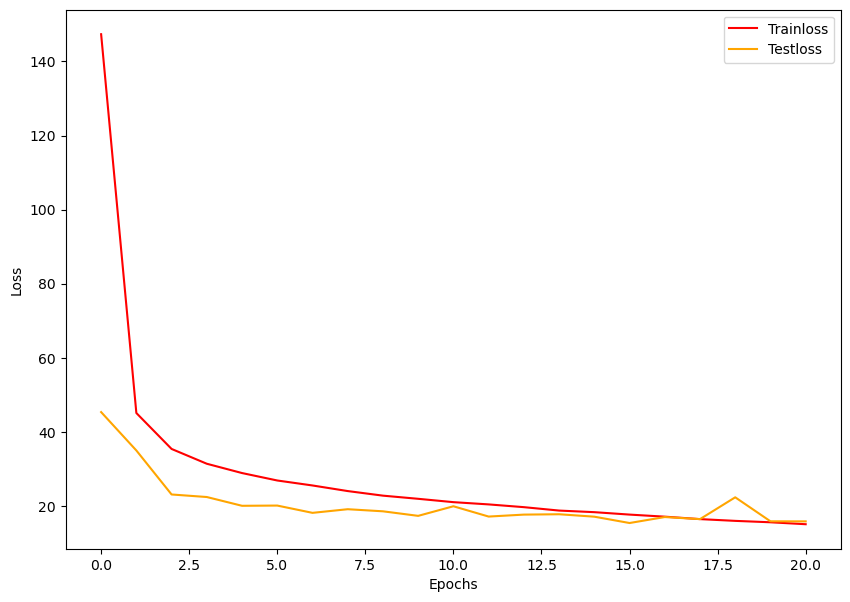

MyResNet_test3
Epoch1:[32000/3662850(1%)]
Epoch1:[64000/3662850(2%)]
	 Train Loss:146.072471, Test Loss:42.921366, Train Acc:50.021%, Test Acc:86.659%
Epoch2:[105257/3662850(3%)]
Epoch2:[137257/3662850(4%)]
	 Train Loss:45.321683, Test Loss:31.471821, Train Acc:85.794%, Test Acc:90.177%
	 Weight Saved
Epoch3:[178514/3662850(5%)]
Epoch3:[210514/3662850(6%)]
	 Train Loss:35.606253, Test Loss:23.345599, Train Acc:89.095%, Test Acc:93.205%
	 Weight Saved
Epoch4:[251771/3662850(7%)]
Epoch4:[283771/3662850(8%)]
	 Train Loss:31.438494, Test Loss:23.926429, Train Acc:90.375%, Test Acc:93.085%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/3662850(9%)]
Epoch5:[357028/3662850(10%)]
	 Train Loss:28.889151, Test Loss:20.518405, Train Acc:91.316%, Test Acc:94.276%
	 Weight Saved
Epoch6:[398285/3662850(11%)]
Epoch6:[430285/3662850(12%)]
	 Train Loss:26.925062, Test Loss:20.421760, Train Acc:91.961%, Test Acc:94.372%
	 Weight Saved
Epoch7:[471542/3662850(13%)]
Epoch7:[503542/3662850(14%)]
	 T

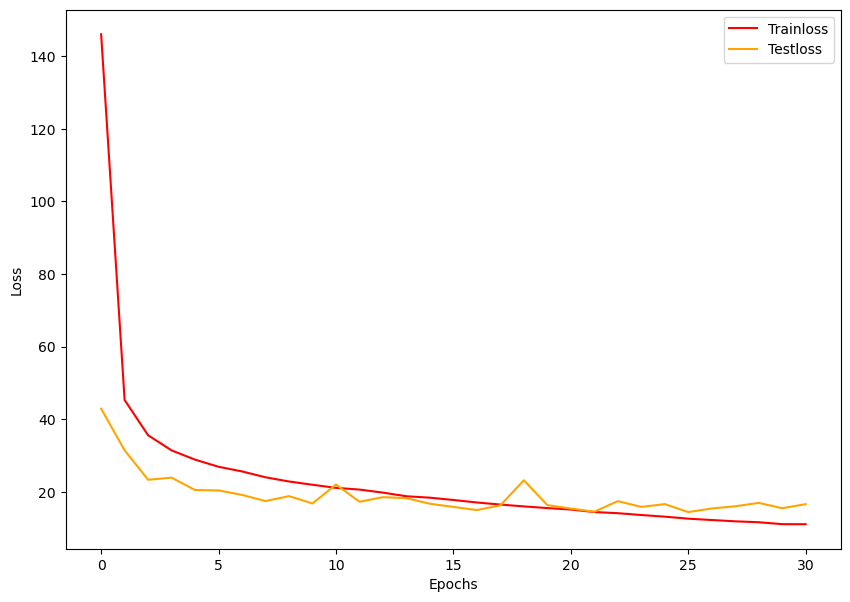

In [131]:
#调小提前停止阈值，再进行三次训练，每次30个epochs

PATH = r"D:\Desktop"

for modelname in ["MyResNet_test1","MyResNet_test2","MyResNet_test3"]:
    print(modelname)
    torch.manual_seed(1412)
    resnet18_ = m.resnet18()
    net = MyResnet().to(device,non_blocking=True)
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=50, bs=256
                                         ,modelname=modelname
                                         ,PATH = PATH
                                         ,tol = 10**(-10))
    print(time()-start)
    plotloss(trainloss,testloss)